In [1]:
from brian2 import *
# set_device('cpp_standalone') # for faster execution - builds a standalone C++ program

import NeuronEquations
import BrianHF
import numpy as np
from bimvee.importAe import importAe
from EvCamDatabase import DAVIS_346B
import os

# TODO XXX: Turn all lists into numpy arrays for the sake of memory efficiency

WARNING    /home/iit.local/bmaacaron/code/ERO-SNN/BrianHF.py:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
 [py.warnings]


In [2]:
# XXX: Extract the event stream using bimvee - needs refactoring to be more general
grid_width, grid_height= DAVIS_346B['width'], DAVIS_346B['height']
filePath = 'MVSEC_short_outdoor'
events = importAe(filePathOrName=filePath)

{'filePathOrName': 'MVSEC_short_outdoor'}
{'filePathOrName': 'MVSEC_short_outdoor'}
{'filePathOrName': 'MVSEC_short_outdoor/leftdvs'}
{'filePathOrName': 'MVSEC_short_outdoor/leftdvs'}
importIitYarp trying path: MVSEC_short_outdoor/leftdvs


100%|██████████| 38292/38292 [00:07<00:00, 4873.04it/s]


Examining info.log: MVSEC_short_outdoor/leftdvs/info.log
{'filePathOrName': 'MVSEC_short_outdoor/rightdvs'}
{'filePathOrName': 'MVSEC_short_outdoor/rightdvs'}
importIitYarp trying path: MVSEC_short_outdoor/rightdvs


100%|██████████| 38024/38024 [00:05<00:00, 6875.80it/s] 


Examining info.log: MVSEC_short_outdoor/rightdvs/info.log


In [3]:
try:
    eventStream = events[0]['data']['left']['dvs']
except:
    eventStream = events[0]['data']['right']['dvs']
eventStream.popitem()

('tsOffset', -0.0)

### Steps for the setting up the network:
1. Generate the input spikes
2. Set the parameters for the network (neurons and synapses)
3. Create the neuron group(s)
4. Create the synapses
5. Connect the synapses
6. Define the weights of the synapses
7. Set up monitors according to need
8. Run the simulation
9. (Optional) Visualize the results

#### _1. Generate the input spikes from the event stream_
###### _Brian Simulation Scope_


In [4]:
tau = 10
vt = 15
vr = 0
v0 = 0 # Currently unused
gL = 1
K_GABA = 1 # Currently unused
K_AMPA = 10 # Currently unused
taugd = 5
tauad = 2  # Currently unused
taugr = 0.25
tauar = 0.5  # Currently unused
w_N = 80
w_G = 30
w_A = 50



defaultclock.dt = 1*us
# HACK XXX: The input is now not in real time, must be fixed eventually to process real time event data
# IMPORTANT NOTE: Output is float, so we need to convert to Quantities (i.e give them units)
simTime, clockStep, inputSpikesGen = BrianHF.event_to_spike(eventStream, grid_width, grid_height, timeScale = 1.0, samplePercentage=1.0)
# defaultclock.dt = clockStep*ms
print("Input event stream successfully converted to spike trains\n")

Extracting the event data...
Polarity was chosen to be ignored. All events are extracted.
Selecting a percentage of the spikes at regular intervals... Percentage:  100.0 %
The maximum x index 326 while the width is 346
The maximum y index 253 while the height is 260
The x,y and time stamp indices are equal, the data is correct.
Checking for duplicate pairs...
No duplicate pairs found.
Total number of pairs/spikes:  10  pairs.
The selected scale is 1.0
The maximum time stamp (scaled) 0.522 ms.
The recommended simulation time (scaled) is 1.0 ms.
The minimum time step (scaled) is 0.522 ms.
The recommended clock time step (scaled) is 0.52 ms.
Input event stream successfully converted to spike trains



#### _2. Set the parameters for the network (neurons and synapses)_
Parameter values can be tuned at the top of the document (this is done for clarity purposes).

In [5]:
# Neuron Parameters
N_Neurons = grid_width * grid_height    # Number of neurons
tau = tau*ms    # Time constant
vt = vt*mV    # Threshold Voltage
vr = vr*mV    # Reset Voltage
v0 = v0*mV    # Resting Voltage - Not necessarily used
gL = gL/ms    # Leak Conductance - Not necessarily used

'''
    Neighborhood Size (num_Neighbors) - Affects the number of neighbors a central neuron based on the L1 Distance
    Neighboring Neurons --> (abs(X_pre - X_post) <= num_Neighbors  and abs(Y_pre - Y_post) <= num_Neighbors)
'''
num_Neighbors = 2    # Number of neighbors

Eqs_Neurons = NeuronEquations.EQ_LIF_N    # Neuron Equations

# Synapse Parameters
K_GABA = K_GABA
K_AMPA = K_AMPA
taugd = taugd * ms
tauad = tauad * ms
taugr = taugr * ms
tauar = tauar * ms


# Generate the dictionary of parameters for the network
networkParams = {'N_N': N_Neurons, 'k': num_Neighbors, 'tau': tau, 'vt': vt, 'vr': vr, 'v0': v0, 'gL': gL,
                 'K_GABA': K_GABA, 'K_AMPA': K_AMPA, 'taugd': taugd, 'tauad': tauad, 'taugr': taugr, 'tauar': tauar, 'w_N': w_N, 'w_G': w_G, 'w_A': w_A}

#### _3. Create the neuron group(s)_

In [6]:
# TODO XXX: The events are running on the clockStep, I should at least fix them to use the (event_driven) setting in Brian2
neuronsGrid = NeuronGroup(N_Neurons, Eqs_Neurons, threshold='v>vt', reset='v = vr')

# FIXME: Verify the grid coordinates and assign the X and Y values to the neurons accordingly
# Generate x and y values for each neuron
x_values = np.repeat(np.arange(grid_width), grid_height)
y_values = np.tile(np.arange(grid_height), grid_width)
neuronsGrid.X = x_values
neuronsGrid.Y = y_values

ValueError: Equations of type 'differential equation' cannot have a flag 'event-driven', only the following flags are allowed: ('unless refractory',)

#### _4. Create the synapses_

In [ ]:
Syn_Input_Neurons = Synapses(inputSpikesGen, neuronsGrid, 'w : volt/second', on_pre='Ia += w') # NOTE: Use Ia1 or Ia depending on the neuron equation used
Syn_Neurons_GABA = Synapses(neuronsGrid, neuronsGrid, 'w : volt/second', on_pre='Ig -= w') # NOTE: Use Ia1 or Ia depending on the neuron equation used
Syn_Neurons_AMPA = Synapses(neuronsGrid, neuronsGrid, 'w : volt/second', on_pre='Ia += w') # NOTE: Use Ia1 or Ia depending on the neuron equation used

#### _5. Connect the synapses_

In [ ]:
Syn_Input_Neurons.connect(condition= 'i==j')    # Connect the first synapses from input to G_neurons on a 1 to 1 basis
Syn_Neurons_GABA.connect(condition='i != j and abs(X_pre - X_post) <= num_Neighbors and abs(Y_pre - Y_post) <= num_Neighbors')    # Connect the second group of synapses from a neuron to its neighbors
Syn_Neurons_AMPA.connect(condition='i == j')     # Connect the last set of synapses from a neuron to itself (recurrent)

#### _6. Define the weights of the synapses_

In [ ]:
Syn_Input_Neurons.w = w_N * volt/second
Syn_Neurons_GABA.w = w_G * volt/second
Syn_Neurons_AMPA.w = w_A * volt/second

#### _7. Set up monitors_

In [ ]:
SpikeMon_Input = SpikeMonitor(inputSpikesGen)    # Monitor the spikes from the input
SpikeMon_Neurons = SpikeMonitor(neuronsGrid)    # Monitor the spikes from the neuron grid
# StateMon_Neurons = StateMonitor(neuronsGrid, variables=True, record=True)    # Monitor the state variables - True for all variables

In [ ]:
# store('PreSim', 'PreSimulationState')    # Store the state of the simulation before running

### _8. Run the simulation_

In [ ]:
print(f"Running the simulation for {simTime} ms")
net = Network(collect())
if 'ipykernel' in sys.modules:
    # Running in a Jupyter notebook
    print("Running in a Jupyter notebook")
    net.run(simTime*ms, profile=True)
    profiling_summary(net)
else:
    # Not running in a Jupyter notebook
    print("Not running in a Jupyter notebook")
    net.run(simTime*ms, report=BrianHF.ProgressBar(), report_period=1*second, profile=True)
    # print(profiling_summary(net))
print("Simulation complete\n")

Running the simulation for 1.0 ms
Running in a Jupyter notebook
Simulation complete



#### _9. (Optional) Visualize the results_

In [ ]:
print("Generating Visualizable Outputs:")
resultPath = 'SimulationResults'
inputStr = BrianHF.filePathGenerator('tempnetIn', networkParams)
outputStr = BrianHF.filePathGenerator('tempnetOut', networkParams)

# Create the folder if it doesn't exist
if not os.path.exists(resultPath):
    os.makedirs(resultPath)

# Create the subfolders if they don't exist
subfolders = ['numpyFrames', 'gifs', 'videos']
for subfolder in subfolders:
    subfolderPath = os.path.join(resultPath, subfolder)
    if not os.path.exists(subfolderPath):
        os.makedirs(subfolderPath)

Generating Visualizable Outputs:


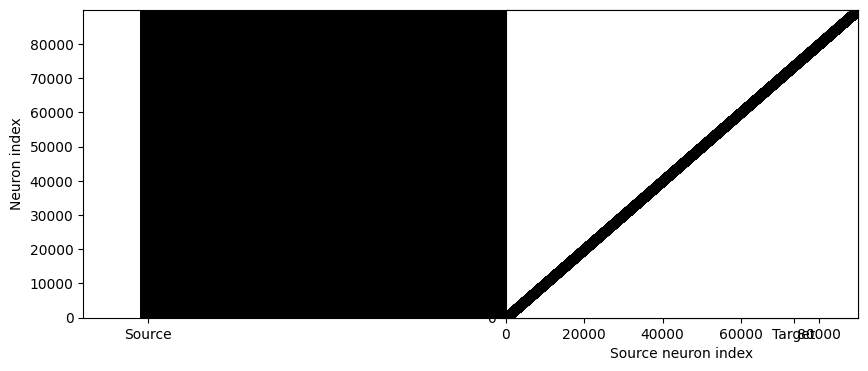

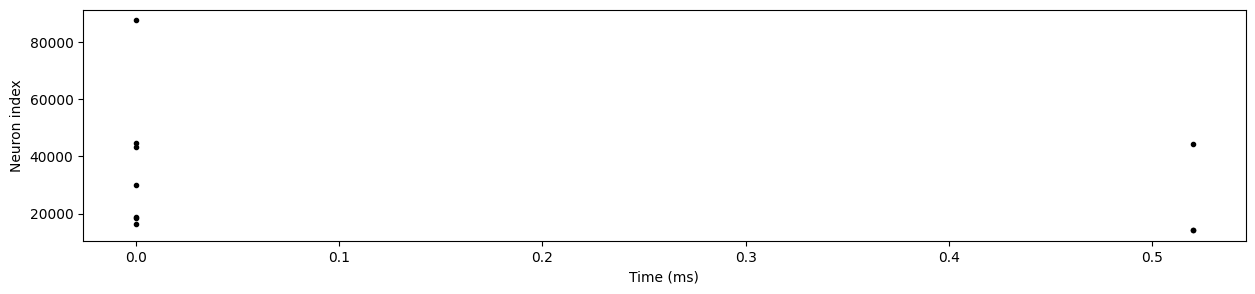

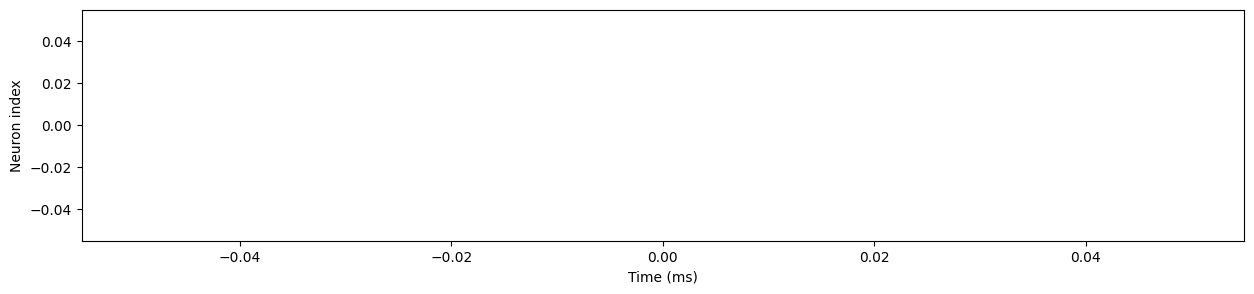

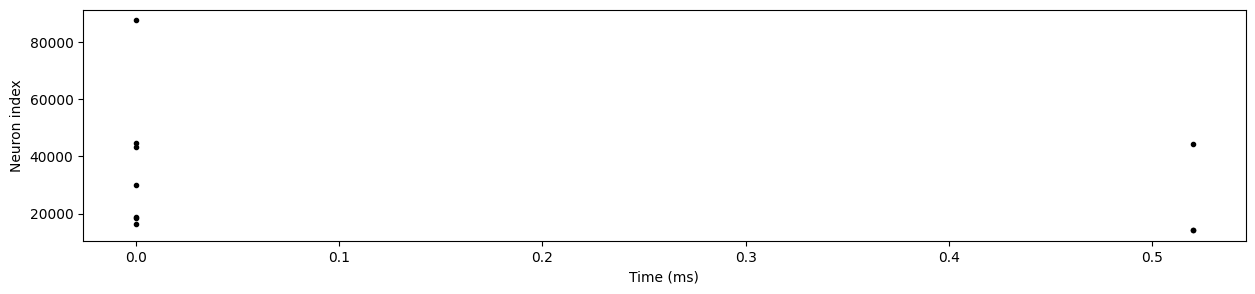

In [ ]:
BrianHF.visualise_connectivity(Syn_Input_Neurons)
BrianHF.visualise_spikes([SpikeMon_Input, SpikeMon_Neurons])
BrianHF.visualise_spike_difference(SpikeMon_Input, SpikeMon_Neurons)

In [ ]:

# Generate the frames for input and output
print("Generating Frames for Input...", end=' ')
inputFrames = BrianHF.generate_frames(SpikeMon_Input, grid_width, grid_height, num_neurons=N_Neurons)
print("Generation Complete.")
print("Generating Frames for Output...", end=' ')
outputFrames = BrianHF.generate_frames(SpikeMon_Neurons, grid_width, grid_height, num_neurons=N_Neurons)
print("Generation Complete.")
# Save the frames
np.save(os.path.join(resultPath, 'numpyFrames', inputStr+'.npy'), inputFrames)
np.save(os.path.join(resultPath, 'numpyFrames', outputStr+'.npy'), outputFrames)

# Generate the GIFs from the frames
print("Generating Input GIF", end=' ')
BrianHF.generate_gif(inputFrames, os.path.join(resultPath, 'gifs', inputStr+'.gif'), simTime, replicateDuration=True, duration=1e-8)
print("Generation Complete.")
print("Generating Output GIF", end=' ')
BrianHF.generate_gif(outputFrames, os.path.join(resultPath, 'gifs', outputStr+'.gif'), simTime, replicateDuration=True ,duration=1e-8)
print("Generation Complete.")

# Generate the Videos from the frames
print("Generating Input Video", end=' ')
BrianHF.generate_video(outputFrames, os.path.join(resultPath, 'videos', inputStr+'.mp4'), simTime)
print("Generation Complete.")
print("Generating Output Video", end=' ')
BrianHF.generate_video(outputFrames, os.path.join(resultPath, 'videos', outputStr+'.mp4'), simTime)
print("Generation Complete.")

Generating Frames for Input... Generation Complete.
Generating Frames for Output... 

ZeroDivisionError: float division by zero

In [ ]:
# store('SimOut', 'SimulationOutput')   # Store the state of the simulation after running

"""
I SHOULD REMOVE THIS
%%
VISUALISATION
BrianHF.visualise_spikes([SpikeMon_Input], figSize=(12,3), figTitle='Input Spikes')
BrianHF.visualise_spikes([SpikeMon_Neurons], figSize=(12,3), figTitle='Output Spikes')

Ploting the interspike interval
BrianHF.visualise_interSpikeInterval(SpikeMon_Neurons, [5])
BrianHF.visualise_neurons_states(StateMon_Neurons, [4, 5], 'all')    
